# Neptune + Fastai
## Before you start
### Install dependencies

In [ ]:
!pip install --quiet neptune-client[fastai] fastai==2.3.1

# Basic Example

**Import libraries**

In [ ]:
import fastai
from fastai.vision.all import *
from neptune.new.integrations.fastai import NeptuneCallback
import neptune.new as neptune
from neptune.new.types import File

## Step 1: Create a Neptune run

To log metadata to the Neptune project, you need the `project name` and the `api_token`.

To make this example easy to follow, we have created a public project **'common/fastai-integration'** and a shared user **'neptuner'** with the API token **'ANONYMOUS'**. As you will see in the code cell below.

**(Optional)** To log to your Neptune project:

* [Create a Neptune account](https://app.neptune.ai/register/)

* [Find your API token](https://docs.neptune.ai/getting-started/installation#authentication-neptune-api-token)
* [Find your project name](https://docs.neptune.ai/getting-started/installation#setting-the-project-name)

Pass your credentials to project and api_token arguments of neptune.init()

`run = neptune.init(api_token='<YOUR_API_TOKEN>', project='<YOUR_WORKSPACE/YOUR_PROJECT>')` # pass your credentials


In [ ]:
run = neptune.init(project='common/fastai-integration', api_token='ANONYMOUS')

**Dataset**

In [ ]:
path = untar_data(URLs.MNIST_TINY)

In [ ]:
dls = ImageDataLoaders.from_csv(path)

In [ ]:
dls.show_batch()

## Step 2: Log metadata using NeptuneCallback()
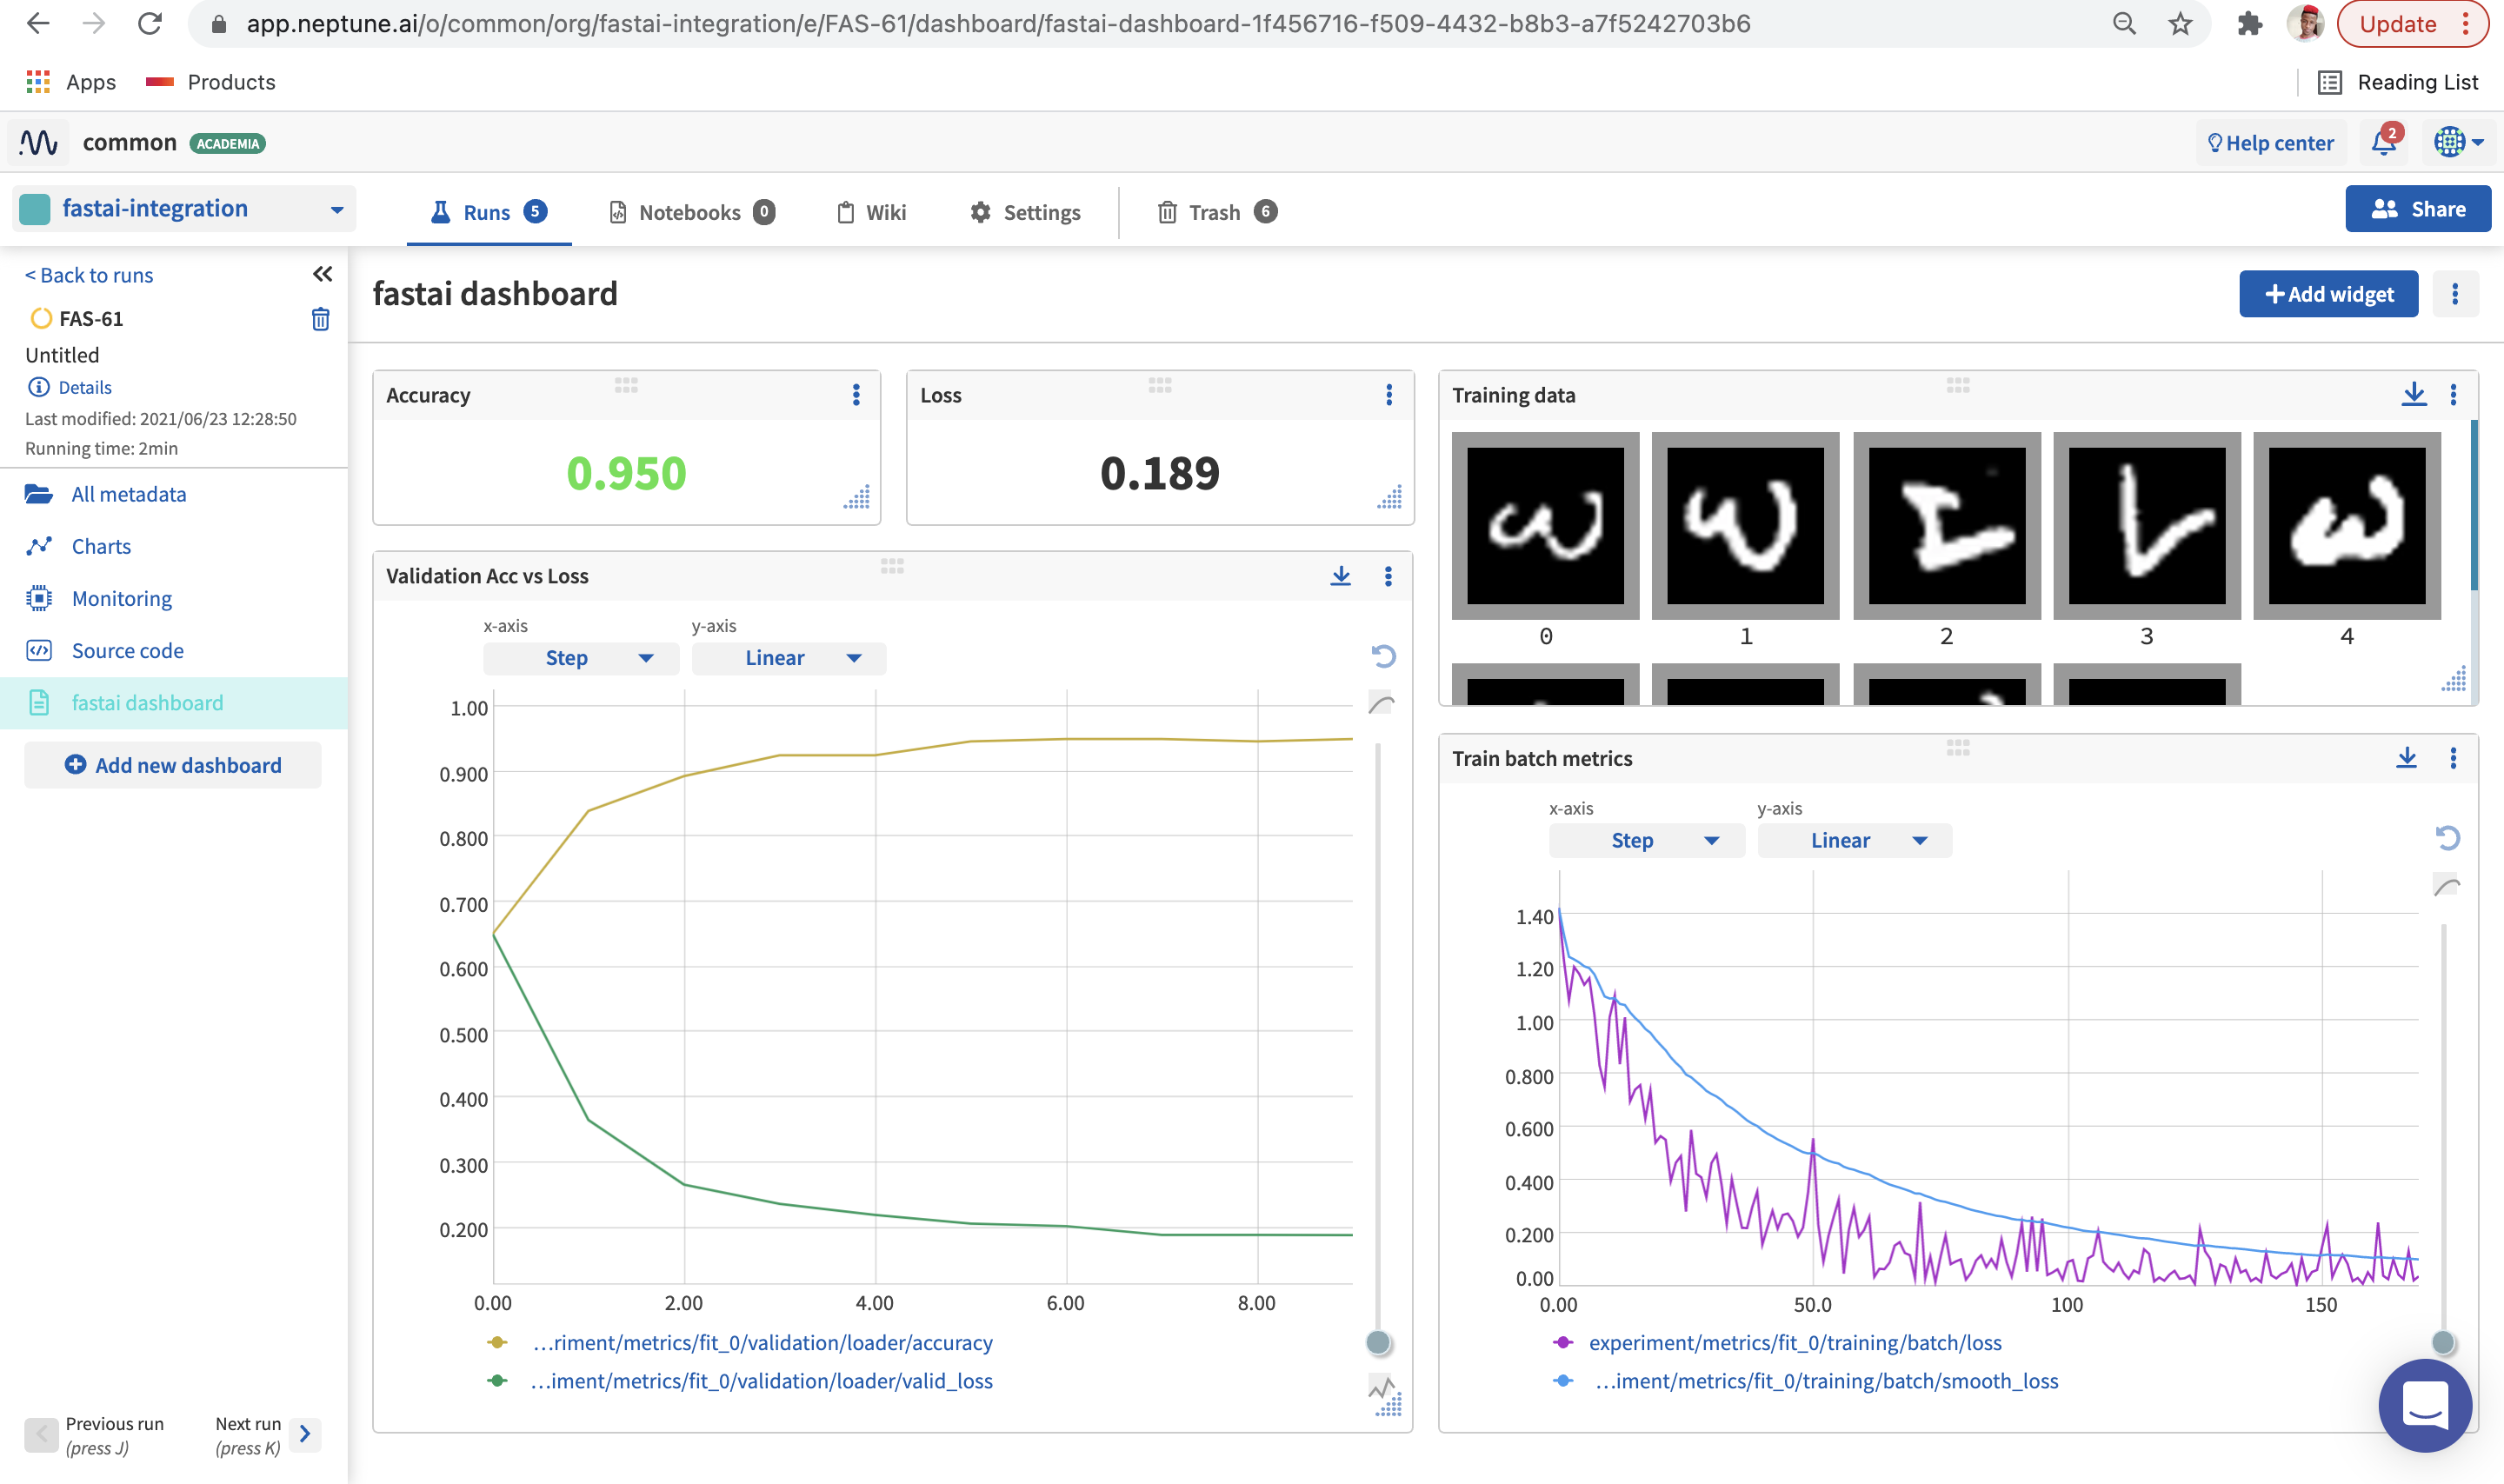
Dashboard:
https://app.neptune.ai/o/common/org/fastai-integration/e/FAS-61/dashboard/fastai-dashboard-1f456716-f509-4432-b8b3-a7f5242703b6


Using NeptuneCallback the following is automatically logged to Neptune UI for you:
- Hyperparameters
- Loss
- Metrics
- Best model weights 
- Model architecture


In [ ]:
learn = cnn_learner(dls, resnet18, cbs=[NeptuneCallback(run, 'experiment')], metrics=accuracy)

In [ ]:
learn.fit_one_cycle(1)

# More options


### Step 3: Single and Multi phase logging

#### Log on a single training phase

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(3, cbs = [NeptuneCallback(run, 'experiment_2', save_best_model=False])

#### Log all training phases of the learner

In [ ]:
learn = cnn_learner(dls, resnet18, metrics = accuracy, cbs=[NeptuneCallback(run, 'experiment_3')])

In [ ]:
learn.fit_one_cycle(2)

In [ ]:
learn.fit_one_cycle(2)

### Step 4: Model weights

1. By default NeptuneCallback() saves and logs the best model for you automatically. 
You can disable it by setting `save_best_model` arg to False.

2. Log Every N epochs

In [ ]:
n = 4
learn = cnn_learner(dls, resnet18, metrics=accuracy, cbs=[NeptuneCallback(run, 'experiment', save_model_freq=n)])

In [ ]:
learn.fit_one_cycle(8)

 3. Add SaveModelCallback 

  If you want to log your model weight files during single training phase then add  SavemodelCallback().

In [ ]:
learn.fit_one_cycle(1, cbs=[SaveModelCallback(), NeptuneCallback(run, 'experiment')])

### Step 5: Log images

In [ ]:
batch = dls.one_batch()
for i, (x,y) in enumerate(dls.decode_batch(batch)):
    # Neptune supports torch tensors
    # fastai uses their own tensor type name TensorImage 
    # so you have to convert it back to torch.Tensor
    run['images/one_batch'].log(
        File.as_image(x.as_subclass(torch.Tensor).permute(2,1,0)/255.), 
        name = f'{i}', description = f'Label: {y}')

# Stop Run

In [ ]:
run.stop()